<a href="https://colab.research.google.com/github/MachineLearnia/Python-Machine-Learning/blob/master/25%20-%20Sklearn%20Ensemble%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 25/30 : Ensemble Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

### fonction de graph des frontières de décision GENIAL !! mis dans outils_visu.py

In [2]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.5)
    
    plt.scatter(X[:,0], X[:,1], c=y, alpha=0.8, edgecolors='k')

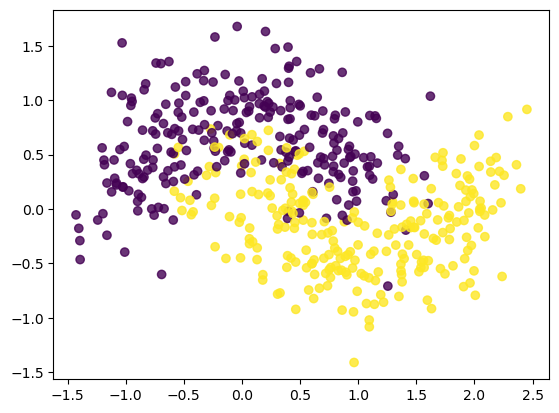

In [3]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=0) # génère 2 demi-lunes aléatoires pour clustering ou classification...
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 1. Voting Classifier - pas terrible car pb du critère de diversité ( ici tous nos models donnenet environ 0.86 dès le départ avant le voting)

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

In [5]:
model_1 = SGDClassifier(random_state=0)
model_2 = DecisionTreeClassifier(random_state=0)
model_3 = KNeighborsClassifier(n_neighbors=2)

model_4 = VotingClassifier([('SGD', model_1),    # entrer une liste de tuple des model avec ('surnom_model', model)
                            ('Tree', model_2),
                            ('KNN', model_3)],
                          voting='hard')                # c'est un vote que pour les classifier, pour les regressor c'est une moyenne
# "hard" prend la majorité du vote, avec "soft" on accume les proba de chaque classe et on prend le meilleur cumule

for model in (model_1, model_2, model_3, model_4):
    model.fit(X_train, y_train)
    print(model.__class__.__name__, model.score(X_test, y_test))

SGDClassifier 0.84
DecisionTreeClassifier 0.86
KNeighborsClassifier 0.86
VotingClassifier 0.8733333333333333


### test voting='soft' ne marche pas à cause du model_1

In [7]:
model_1 = SGDClassifier(random_state=0, loss='log_loss')  # il faut rajouter loss='log' pour éviter l'erreur du loss='hinge' par défaut, loss=perte, hinge donne un support vecteur machine
model_2 = DecisionTreeClassifier(random_state=0)
model_3 = KNeighborsClassifier(n_neighbors=2)

model_4 = VotingClassifier([('SGD', model_1),
                            ('Tree', model_2),
                            ('KNN', model_3)],
                          voting='soft')   # il faut que tous les models émettent des probabilité pour que 'solf' fonctionne

for model in (model_1, model_2, model_3, model_4):
    model.fit(X_train, y_train)
    print(model.__class__.__name__,  model.score(X_test, y_test))

SGDClassifier 0.8333333333333334
DecisionTreeClassifier 0.86
KNeighborsClassifier 0.86
VotingClassifier 0.8666666666666667


## 2. Bagging

In [8]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [11]:
model = BaggingClassifier(estimator=KNeighborsClassifier(),  # l'estimateur de base est un classifier
                         n_estimators=100)  # nbre d'estimateur dans notre foule ( par défaut=100 )

model.fit(X_train, y_train)
model.score(X_test, y_test) # -> 0.88 donc le bagging est meilleur que le voting car on a de la diversité

0.8866666666666667

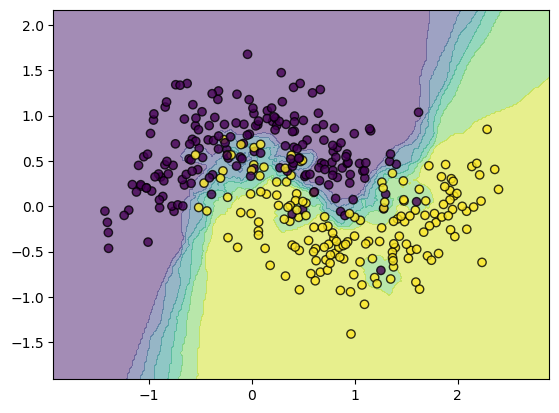

In [12]:
plot_decision_boundary(model, X_train, y_train)

In [13]:
model = RandomForestClassifier(n_estimators=100) # le base_estimateur est un arbre de décision par défaut
# jouer avec l'hyperparam max_depth ( + taille est grande + c'est bon mais il faudra augmenter n_estimateur car overfitting)
model.fit(X_train, y_train)
model.score(X_test, y_test)  # -> 0.866 -> 0.88 si max_depth=20 et n_estimator=1000 mais bcp de calculs

0.88

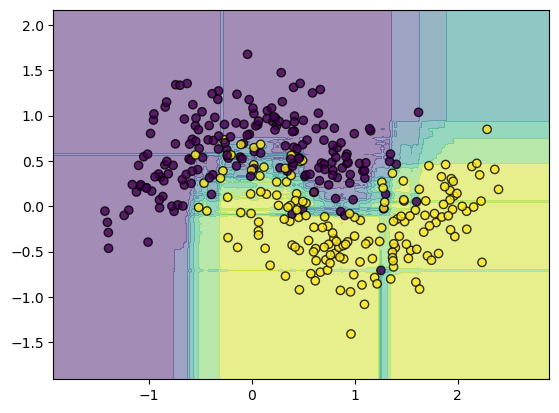

In [14]:
plot_decision_boundary(model, X_train, y_train)

## 3. Boosting

In [15]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [16]:
model = AdaBoostClassifier(n_estimators=100) # base_estimators= arbre de décision par défaut, learning_rate à jouer
# utiliser une gridsearchCV pour optimiser les hyperparam
model.fit(X_train, y_train)
model.score(X_test, y_test)  # -> 0.88 ici

0.88

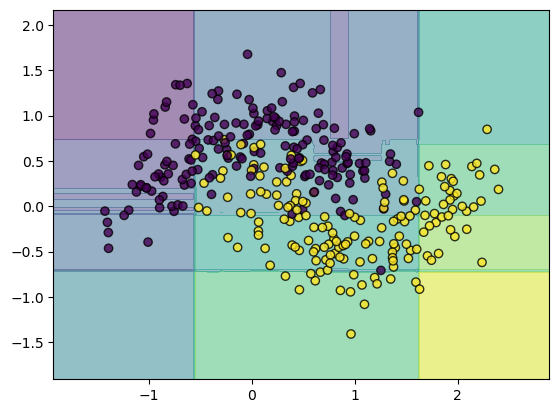

In [17]:
plot_decision_boundary(model, X_train, y_train)

## 4. Stacking - entraine un estimateur par desus nos différents models

In [18]:
from sklearn.ensemble import StackingClassifier

In [19]:
model = StackingClassifier([('SGD', model_1),
                            ('Tree', model_2),
                            ('KNN', model_3)],
                             final_estimator=KNeighborsClassifier())
# les 3 1ers model constituent notre foule, le final_estimateur fera ses prédictions sur notre foule
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.88

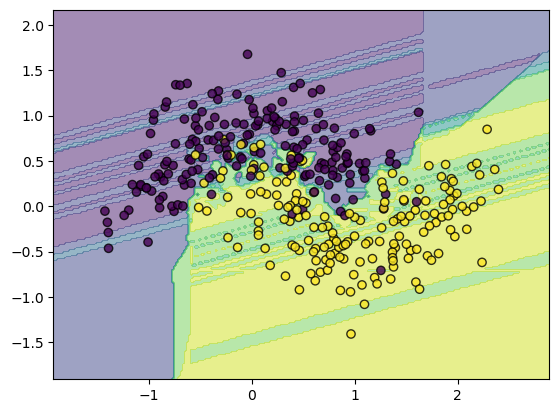

In [20]:
plot_decision_boundary(model, X_train, y_train)